# Brain MRI Classification Using Deep Learning

## Imports

In [119]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Add, GlobalAveragePooling2D, Activation, BatchNormalization, DepthwiseConv2D, SpatialDropout2D
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance # Import the Image and ImageEnhance modules from PIL
from tensorflow.keras.applications import EfficientNetB0

from sklearn.utils import shuffle
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg


## Setup and Dataset Loading

In [10]:
from google.colab import files
files.upload()          # ‣ choose the kaggle.json file you downloaded from your Kaggle account

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/          # move it into the default location
!chmod 600 ~/.kaggle/kaggle.json    # restrict permissions


Saving kaggle.json to kaggle.json


In [11]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [12]:
!unzip -q brain-tumor-mri-dataset.zip -d data

In [4]:
# Directory structure after extraction
dataset_base_dir = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_base_dir, "Training")
test_dir = os.path.join(dataset_base_dir, "Testing")

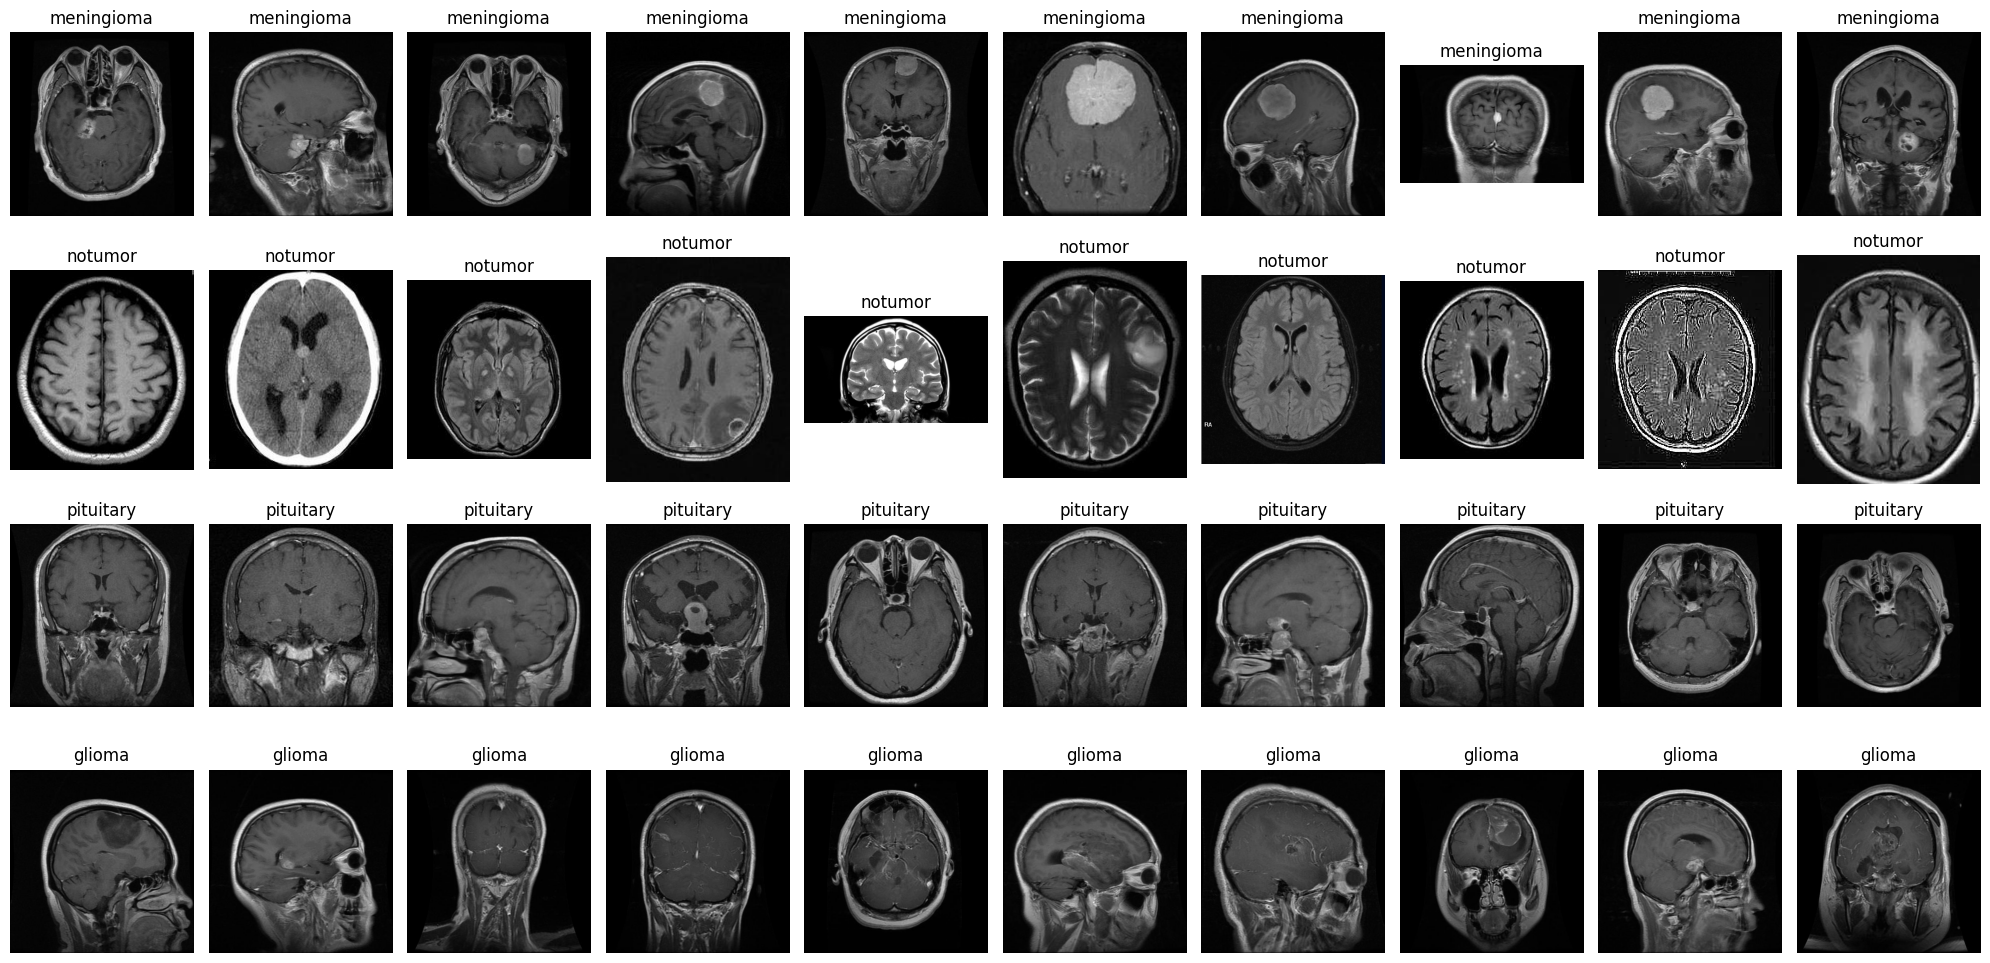

In [5]:
num_samples = 10

categories = ['meningioma', 'notumor', 'pituitary', 'glioma']
category_dirs = {cat: os.path.join(train_dir, cat) for cat in categories}


plt.figure(figsize=(20, 10))

for idx, (category, category_path) in enumerate(category_dirs.items()):
    sample_images = random.sample(os.listdir(category_path), num_samples)

    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(category_path, image_name)
        img = mpimg.imread(image_path)

        # Plot each image
        plt.subplot(len(categories), num_samples, idx * num_samples + i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')

plt.tight_layout()
plt.show()

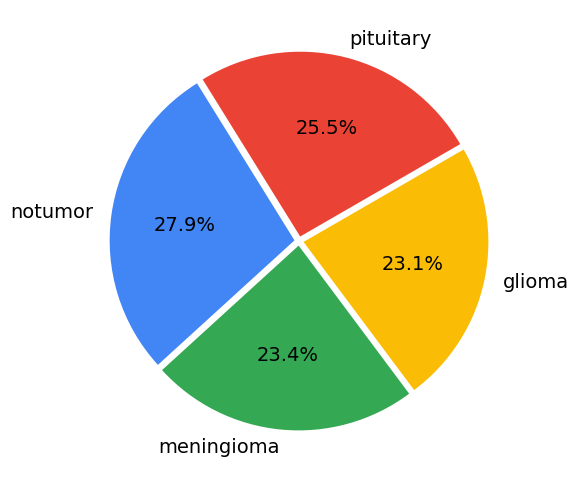

In [23]:
plt.figure(figsize=(14,6))
colors = ['#ea4335', '#4285f4', '#34a853', '#fbbc05']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

In [130]:
# General Imports
import os, random, numpy as np, tensorflow as tf, torch
import matplotlib.pyplot as plt, seaborn as sns
from PIL import Image, ImageEnhance
from sklearn.metrics import confusion_matrix, classification_report

In [103]:
import os, random, numpy as np, tensorflow as tf
SEED = 42; IMG_SIZE = (128,128); BATCH_SIZE = 20; EPOCHS = 10
DATA_DIR  = "/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

### Function for confusion‑matrix plot

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

## VGG16

In [105]:
from PIL import Image, ImageEnhance

def pil_augment(img):
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8,1.2))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8,1.2))
    return img

datagen_vgg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
    rotation_range=15, horizontal_flip=True)

train_vgg = datagen_vgg.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=SEED)

val_vgg   = datagen_vgg.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

NUM_CLASSES = len(train_vgg.class_indices)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### VGG16 Definition

In [108]:
# %% --------------------------------------------------------------------------
from tensorflow.keras import layers, models, optimizers, applications, metrics

base = applications.VGG16(include_top=False, weights="imagenet",
                          input_shape=(*IMG_SIZE, 3))
for lyr in base.layers: lyr.trainable = False
for name in ["block5_conv1","block5_conv2","block5_conv3"]:
    base.get_layer(name).trainable = True

x = layers.Flatten()(base.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

vgg16_model = models.Model(base.input, outputs, name="VGG16_brainMRI")
vgg16_model.compile(                                      
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",                      
    metrics=[metrics.CategoricalAccuracy(name="accuracy"),
             metrics.Precision(name="precision"),
             metrics.Recall(name="recall")])
vgg16_model.summary()


Model: "VGG16_brainMRI"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Training

In [109]:
history_vgg = vgg16_model.fit(train_vgg, epochs=EPOCHS, validation_data=val_vgg)


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 45s 137ms/step - accuracy: 0.7088 - loss: 0.6914 - precision: 0.7703 - recall: 0.6311 - val_accuracy: 0.8612 - val_loss: 0.3863 - val_precision: 0.8696 - val_recall: 0.8497
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - accuracy: 0.9069 - loss: 0.2559 - precision: 0.9164 - recall: 0.8948 - val_accuracy: 0.9054 - val_loss: 0.2358 - val_precision: 0.9177 - val_recall: 0.9016
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.9293 - loss: 0.1851 - precision: 0.9371 - recall: 0.9237 - val_accuracy: 0.9405 - val_loss: 0.1729 - val_precision: 0.9438 - val_recall: 0.9344
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - accuracy: 0.9518 - loss: 0.1350 - precision: 0.9545 - recall: 0.9486 - val_accuracy: 0.9375 - val_loss: 0.1729 - val_precision: 0.9422 - val_recall: 0.9321
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - accuracy: 0.9431 - loss: 0.1561 - precision: 0.9461 - recall: 0.9378 - val_accuracy: 0.9695

### Evaluation

              precision    recall  f1-score   support

      glioma       1.00      0.94      0.97       300
  meningioma       0.97      0.95      0.96       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



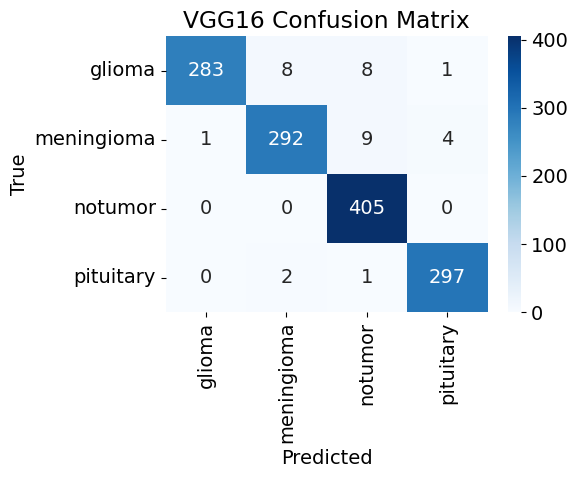

In [110]:
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = [], []
for xb, yb in val_vgg:
    preds = np.argmax(vgg16_model.predict(xb, verbose=0), axis=1)
    y_true.extend(np.argmax(yb, axis=1))   # one‑hot → integer
    y_pred.extend(preds)
    if len(y_true) >= val_vgg.n: break

labels = list(train_vgg.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("VGG16 Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


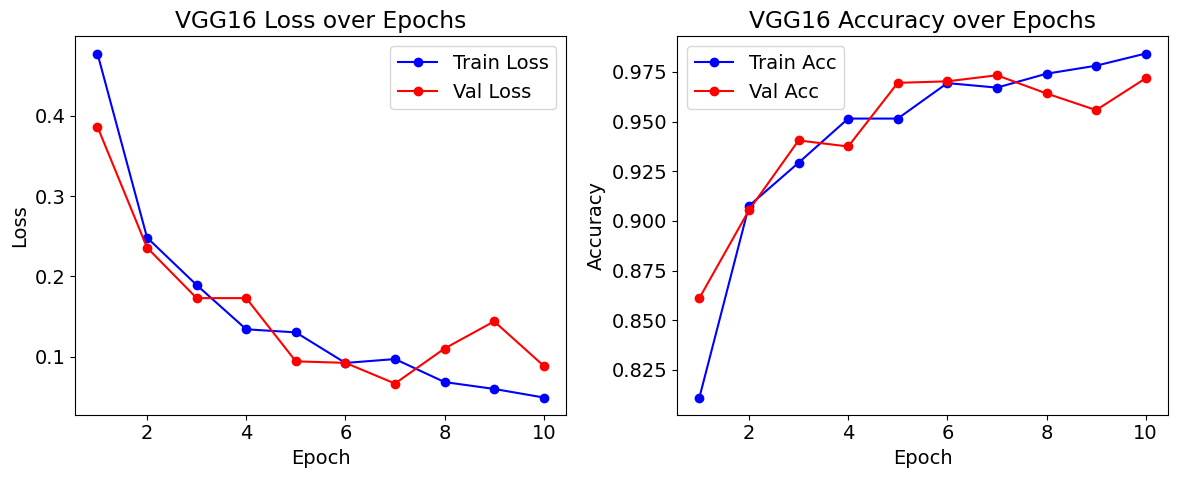

In [144]:
def plot_vgg_training_history(history):

    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Val Loss')
    plt.title('VGG16 Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Val Acc')
    plt.title('VGG16 Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

# Call the function after training the VGG16 model
plot_vgg_training_history(history_vgg)

## ResNet18

In [131]:
# PyTorch ResNet18 Block
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

### ResNet18 Definition

In [133]:
def get_pytorch_loaders(train_dir, test_dir, batch_size=16):
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    train_dataset = ImageFolder(train_dir, transform=data_transforms)
    test_dataset = ImageFolder(test_dir, transform=test_transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, train_dataset.classes

def get_resnet_model(num_classes=4):
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:
            param.requires_grad = True
    model.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )
    return model

In [136]:
from sklearn.metrics import precision_score, recall_score
import time, sys

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=15):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        y_true_train, y_pred_train = [], []

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_prec = precision_score(y_true_train, y_pred_train, average='macro')
        train_rec = recall_score(y_true_train, y_pred_train, average='macro')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())

        val_loss /= len(test_loader)
        val_acc = correct / total
        val_prec = precision_score(y_true_val, y_pred_val, average='macro')
        val_rec = recall_score(y_true_val, y_pred_val, average='macro')

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        elapsed = time.time() - start_time
        ms_per_step = (elapsed / len(train_loader)) * 1000

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{len(train_loader)}/{len(train_loader)} ━━━━━━━━━━━━━━━━━━━━ "
              f"{int(elapsed)}s {int(ms_per_step)}ms/step - "
              f"accuracy: {train_acc:.4f} - loss: {train_loss:.4f} - "
              f"precision: {train_prec:.4f} - recall: {train_rec:.4f} - "
              f"val_accuracy: {val_acc:.4f} - val_loss: {val_loss:.4f} - "
              f"val_precision: {val_prec:.4f} - val_recall: {val_rec:.4f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), 'best_pytorch_model.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies


### Training ResNet18

In [ ]:
train_loader, test_loader, class_names = get_pytorch_loaders(TRAIN_DIR, TEST_DIR)
model = get_resnet_model(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=15
)


Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.8589 - loss: 0.4058 - precision: 0.8542 - recall: 0.8539 - val_accuracy: 0.8970 - val_loss: 0.2760 - val_precision: 0.8984 - val_recall: 0.8901
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.9193 - loss: 0.2583 - precision: 0.9171 - recall: 0.9162 - val_accuracy: 0.9237 - val_loss: 0.2580 - val_precision: 0.9285 - val_recall: 0.9184
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.9321 - loss: 0.2078 - precision: 0.9300 - recall: 0.9295 - val_accuracy: 0.9672 - val_loss: 0.1116 - val_precision: 0.9666 - val_recall: 0.9651
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 50s 140ms/step - accuracy: 0.9484 - loss: 0.1599 - precision: 0.9471 - recall: 0.9467 - val_accuracy: 0.9474 - val_loss: 0.1294 - val_precision: 0.9501 - val_recall: 0.9428
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.9562 - loss: 0.1299 - precision: 0.9548 - recall: 0.9545 - val_accuracy: 0.9634

### Evaluation ResNet18

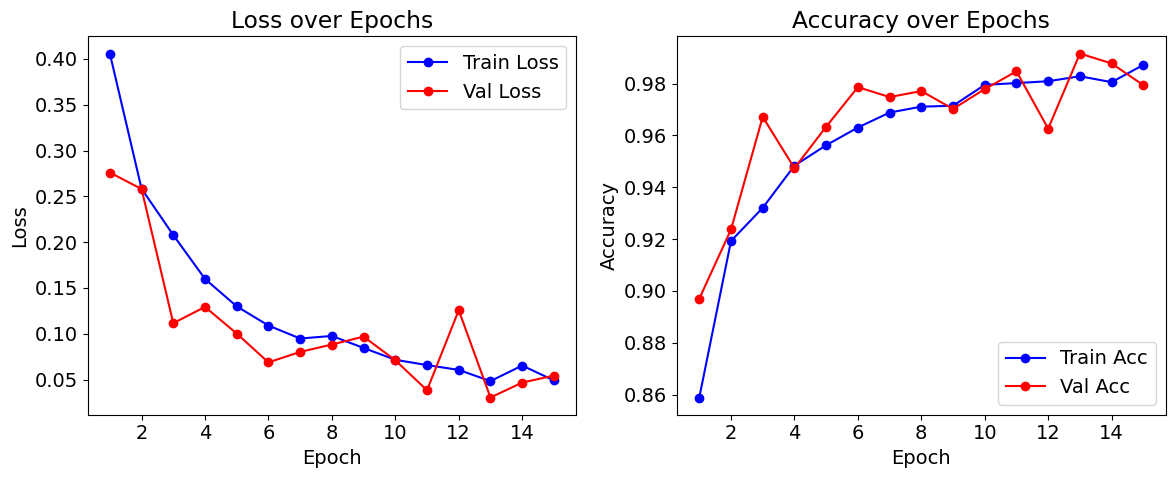

In [138]:
def plot_training_history(train_losses, val_losses, train_acc, val_acc):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Train Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("ResNet18 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))


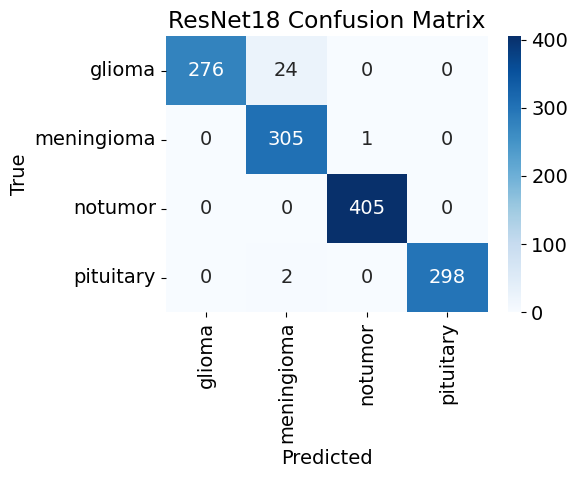

Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96       300
  meningioma       0.92      1.00      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [140]:
evaluate_model(model, test_loader, class_names)


In [146]:
# Save as SavedModel format (recommended for TensorFlow Serving and FastAPI)
vgg16_model.save('vgg16_brain_mri_model.h5')

In [149]:
import torch
import h5py
import numpy as np
import torchvision.models as models
import torch.nn as nn

def get_resnet_model(num_classes=4):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )
    return model

# Load your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = get_resnet_model(num_classes=4)

try:
    # Try to load existing weights first
    from torch.serialization import safe_globals
    from torchvision.models.resnet import ResNet
    
    with safe_globals([ResNet]):
        loaded_model = torch.load('resnet18_weights.pth', map_location=device)
        
        # Check if it's a state_dict or full model
        if isinstance(loaded_model, dict):
            resnet_model.load_state_dict(loaded_model)
        else:
            resnet_model = loaded_model
except Exception as e:
    print(f"Could not load weights: {str(e)}")

# Save model state_dict to H5 format
def save_pytorch_model_to_h5(model, filename):
    state_dict = model.state_dict()
    with h5py.File(filename, 'w') as h5f:
        # Save model architecture as an attribute
        h5f.attrs['architecture'] = 'resnet18'
        h5f.attrs['num_classes'] = 4
        
        # Save each layer's weights and biases
        for key, value in state_dict.items():
            h5f.create_dataset(key, data=value.cpu().numpy())
    print(f"Model saved to {filename}")

# Save the model
save_pytorch_model_to_h5(resnet_model, 'resnet18_model.h5')

# Function to load the model back from H5
def load_pytorch_model_from_h5(filename, model=None):
    if model is None:
        # Create a new model if none provided
        num_classes = 4  # Default
        with h5py.File(filename, 'r') as h5f:
            if 'num_classes' in h5f.attrs:
                num_classes = h5f.attrs['num_classes']
        model = get_resnet_model(num_classes=num_classes)
    
    # Load weights
    state_dict = {}
    with h5py.File(filename, 'r') as h5f:
        for key in h5f.keys():
            state_dict[key] = torch.tensor(np.array(h5f[key]))
    
    model.load_state_dict(state_dict)
    return model

# Test loading the model back
print("Testing loading the saved H5 model...")
loaded_model = load_pytorch_model_from_h5('resnet18_model.h5')
print("Model loaded successfully!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/3029046517.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model saved to resnet18_model.h5
Testing loading the saved H5 model...
Model loaded successfully!
